In [1]:
from matplotlib import pyplot as plt
import numpy as np
import warnings
from typing import List, Tuple
import sys
sys.path.append('../')
from common_util import NogamiUEData,setup_axis_default,get_k_most_commmon_feature_transform, ProjectPaths,setup_plotting_format

#ignore warnings and set preference for matplotlib styles
warnings.filterwarnings("ignore")
setup_plotting_format()
paths = ProjectPaths()


#load data
class ModifiedNogamiData(NogamiUEData):

    def __init__(self,threshold: float):
        super().__init__()
        self.threshold = threshold

    def __getitem__(self, key: str) -> Tuple[np.ndarray]:
        x,y  = super().__getitem__(key)
        index = x.squeeze() > self.threshold
        return x[index],y[index]
    
nogami_data = ModifiedNogamiData(threshold = 150)

### Feature Selection 

This model has the same goals and approach as discussed in the [uts_modeling.ipynb](uts_modeling.ipynb) notebook, so take a look at that first to understand the methodology. Additionally, due to processes that we cannot model given our current information, the measured uniform elongation exhibits very different behavior for $T \geq T_0$ $^\circ \text{C}$ then $T < T_0$ $^\circ \text{C}$. However, for the application, we don't care about the model for $T < 200$ $^\circ \text{C}$, so we'll discard this data and refit the model. 

Finally, the original paper remarks that for pure $W$ the material has essentially recrystallized, leading to the enourmous measured UE. We'll discard this data point as well.

In [2]:

from common_util import TransformedFeature, identity,inverted,xlogx,power,function_product
from functools import partial

def clean_data(x: np.ndarray,y: np.ndarray,remove_points: List[int]):
    mask = np.ones_like(x.squeeze(),dtype = bool)
    mask[remove_points] = False
    return x[mask],y[mask]

remove_data = {'UE [%] W Plate (H)': [6]}

features = [TransformedFeature('x',identity),
            TransformedFeature('log x',np.log),
            TransformedFeature('x^0.5',np.sqrt),
            TransformedFeature('1/x',inverted),    
            TransformedFeature('x^2',partial(power,2)),
            TransformedFeature('x log x',xlogx),
            TransformedFeature('x^3',partial(power,3)),
            TransformedFeature('x^2 log x',partial(function_product,partial(power,2),np.log)),
            TransformedFeature('x^3 log x',partial(function_product,partial(power,3),np.log))] 


data= [clean_data(*nogami_data[key],remove_data[key]) if key in remove_data else nogami_data[key] for key in nogami_data.keys()]

feature_transform = get_k_most_commmon_feature_transform(data,3,input_features= features[:])

print(f'selected features: {str(feature_transform)}')

data_transform = feature_transform.make_sklearn_transform()

selected features: ['1', '1/x', 'x^2', 'x']


### Model Visualization

We can already see that there are some poential issues with the data, or at least the model fit to the data.

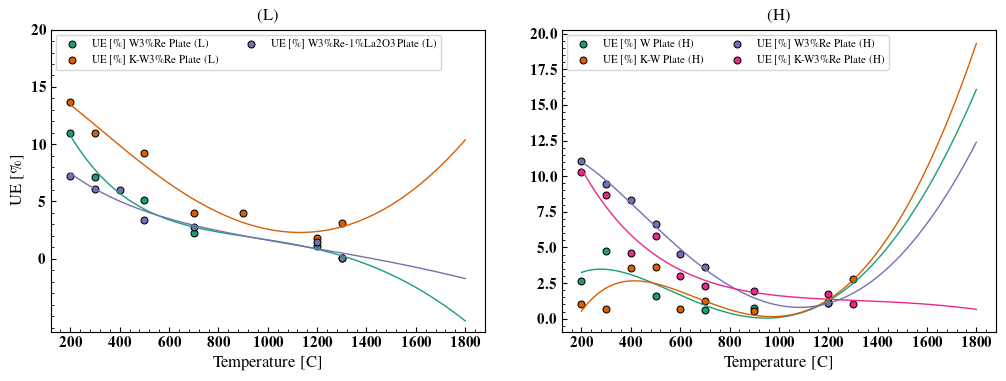

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

fig,axes = plt.subplots(figsize = (10,3.75),ncols = 2)

remove_data = {'UE [%] W Plate (H)': [6]}

for ax,rolling in zip(axes.ravel(),['L','H']):
    setup_axis_default(ax)
    ax.set_title(f'({rolling})')
    columns = [col for col in  nogami_data.keys() if '(' + rolling + ')' in col]
    for i,column in enumerate(columns):
        color = i/len(nogami_data.keys())
        x,y = nogami_data[column]
        if column in remove_data:
            x,y = clean_data(x,y,remove_data[column])

        xp = np.linspace(x.min(),1800,1000)[:,np.newaxis]

        pipe = Pipeline([('transform',data_transform),
                         ('model',LinearRegression(fit_intercept= False))])

        pipe.fit(x,y)
        y_pred = pipe.predict(xp)
        ax.plot(xp,y_pred,lw = 1.,zorder = 100,
                color = plt.get_cmap('Dark2')(color))

        ax.scatter(x,y,s = 25,edgecolor = 'k',
                lw = 0.75,facecolor = plt.get_cmap('Dark2')(color),
                label = column.replace('%','\%'))
    
    ax.legend(loc = 'upper left',fontsize = 8,ncols = 2)

    ax.set_xlabel('Temperature [C]',fontsize = 12)

axes[0].set_yticks(np.arange(0,25,5))
axes[0].set_ylabel('UE [\%]',fontsize = 12)
fig.tight_layout(pad = 0.5) 

### Residual Analysis

examining the residual plots below confirms our hypothesis. Discarding some of the outlier points may help the issue.

UE [%] W Plate (H) doesnt have enough data to calculate studentized residuals
UE [%] K-W Plate (H) possible outliers:
	index: [2]
	studentized residuals: [-3.28050564]

--------------------------------------------


UE [%] W3%Re Plate (H) possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


UE [%] K-W3%Re Plate (H) possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


UE [%] W3%Re Plate (L) possible outliers:
	index: [2]
	studentized residuals: [10.54945716]

--------------------------------------------


UE [%] K-W3%Re Plate (L) possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


UE [%] W3%Re-1%La2O3 Plate (L) possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------




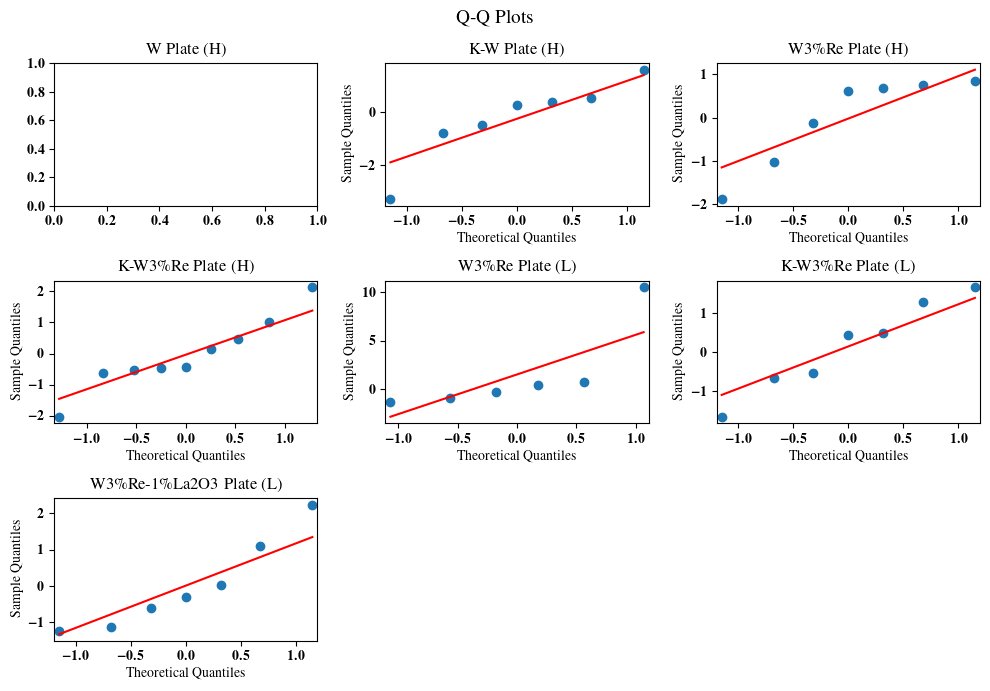

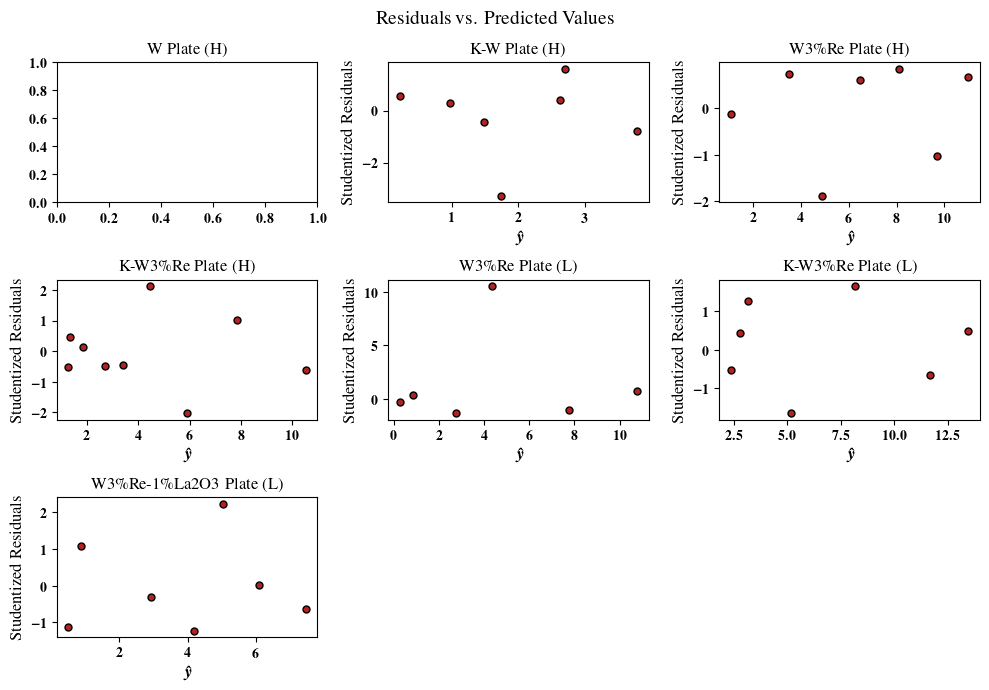

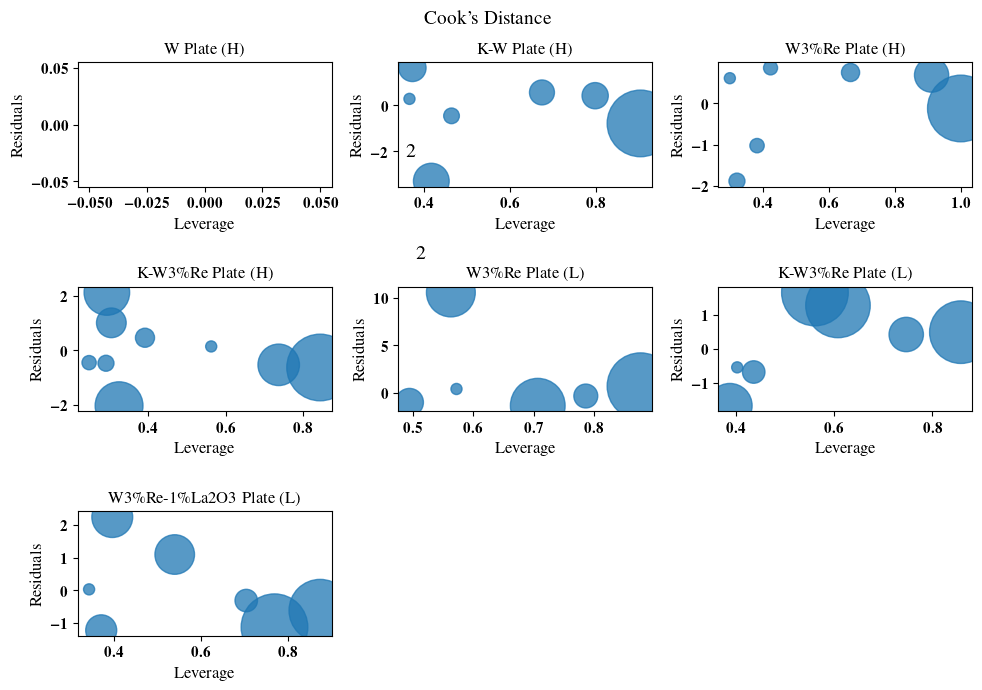

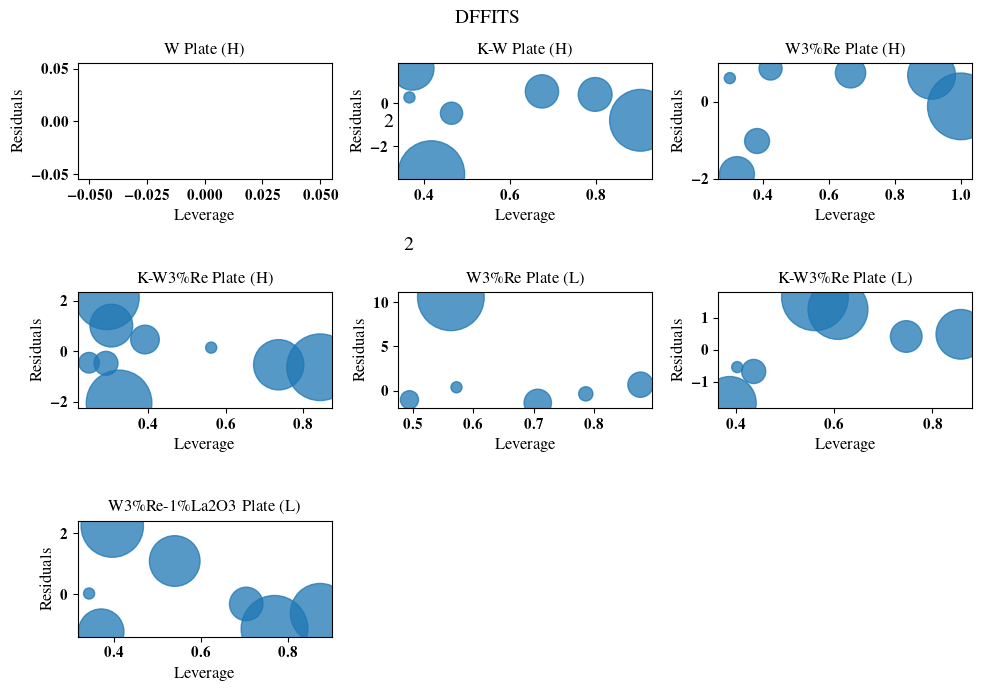

In [4]:
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.regressionplots import influence_plot
from statsmodels.regression.linear_model import OLS as sm_OLS
import scipy

remove_data = {'UE [%] W Plate (H)': [0,6],
               'UE [%] K-W Plate (H)': [0,1]}
               

fig,axes = plt.subplots(figsize = (10,7),nrows = 3,ncols = 3)
fig2,axes2 = plt.subplots(figsize = (10,7),nrows = 3,ncols = 3)
fig3,axes3 = plt.subplots(figsize = (10,7),nrows = 3,ncols = 3)
fig4,axes4 = plt.subplots(figsize = (10,7),nrows = 3,ncols = 3)

fig.suptitle('Q-Q Plots',fontsize = 14)
fig2.suptitle('Residuals vs. Predicted Values',fontsize = 14)
fig3.suptitle('Cook\'s Distance',fontsize = 14)
fig4.suptitle('DFFITS',fontsize = 14)

for column,ax,ax2,ax3,ax4 in zip(nogami_data.keys(),axes.ravel(),axes2.ravel(),axes3.ravel(),axes4.ravel()):
    label = column[6:].replace('%','\%')
    for a in [ax,ax2]:
        a.set_title(r'' + label)

    x,y = nogami_data[column]
    if column in remove_data:
        x,y = clean_data(x,y,remove_data[column])
    
    xp = np.linspace(x.min(),x.max(),1000)[:,np.newaxis]

    #make model-data transform pipeline
    pipe = Pipeline([('transform',data_transform),
                        ('model',LinearRegression(fit_intercept= False))])

    pipe.fit(x,y)
    
    #post-porcessing to get diagnostic information
    resid = y - pipe.predict(x)
    X = pipe.named_steps['transform'].transform(x)

    #somewhat annoying, but we need to refit the model to work with statsmodels
    #diagnostic plots. I don't want to code these up myself, so I'll just do it
    sm_ols_res = sm_OLS(y,X).fit()

    #influence plots - cooks distance
    influence_plot(sm_ols_res,ax = ax3,criterion = 'cooks')

    #influence plots - DFFITS
    influence_plot(sm_ols_res,ax = ax4,criterion = 'dffits')

    #really annoying that I can't seem to modify this with keyword arguments to "influence_plot"
    for a in [ax3,ax4]:
        a.set_xlabel('Leverage',fontsize = 12)
        a.set_ylabel('Residuals',fontsize = 12)
        a.tick_params('both',labelsize = 11)
        a.set_title(label,fontsize = 12)

    #potential outliers
    try:
        n,p = X.shape
        H = X @ scipy.linalg.pinvh(X.T @ X) @ X.T         
        S2 = np.sum(resid**2)/(n - p)
        S2_i = (n - p)/(n- p - 1)*S2 - 1/(n-p -1)*resid**2/(1 - np.diag(H))
        studentized_residuals = resid/np.sqrt(S2_i*(1 - np.diag(H)))
        
        #print informatoin about potential misfits of data for each data set
        possible_outliers = np.arange(X.shape[0])[np.abs(studentized_residuals) > 3]
        
        print(f'{column} possible outliers:')
        print(f'\tindex: {possible_outliers}')
        print(f'\tstudentized residuals: {studentized_residuals[possible_outliers]}')

        print('\n--------------------------------------------\n\n')
        
        #plot residuals against predicted values and qqplots
        qqplot(studentized_residuals,ax = ax,line = 's',
            color = 'blue')
        ax2.scatter(H @ y,studentized_residuals,edgecolor = 'k',
                    facecolor = 'firebrick',s = 25)
        ax2.set_ylabel('Studentized Residuals',fontsize = 12)
        ax2.set_xlabel('$\hat{y}$',fontsize = 12)
    except ZeroDivisionError:
        print(f'{column} doesnt have enough data to calculate studentized residuals')


for ax in [axes,axes2,axes3,axes4]:
    ax[-1,-1].axis('off')
    ax[-1,-2].axis('off') 

for f in [fig,fig2,fig3,fig4]:
    f.tight_layout()

### Removing Potential Outliers and Re-Fitting the Model

We'll remove the potential outliers from the data, and see if this improves the residual fit. 

This does, however the amount of data per alloy is now so low in some cases we can't even compute externally studentized residuals. Also plotted are externally studentized residuals _vs._ fitted values $\hat{y}$

Alloy: UE [%] W Plate (H) | Data Length: 5
possible leverage points: []
possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


Alloy: UE [%] K-W Plate (H) | Data Length: 6
possible leverage points: []
possible outliers:
	index: [2]
	studentized residuals: [-4.38954172]

--------------------------------------------


Alloy: UE [%] W3%Re Plate (H) | Data Length: 7
possible leverage points: []
possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


Alloy: UE [%] K-W3%Re Plate (H) | Data Length: 9
possible leverage points: []
possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


Alloy: UE [%] W3%Re Plate (L) | Data Length: 5
possible leverage points: []
possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


Alloy: UE [%] K-W3%Re Plate (L) | Data Length: 7
possible leverage points: []
possible 

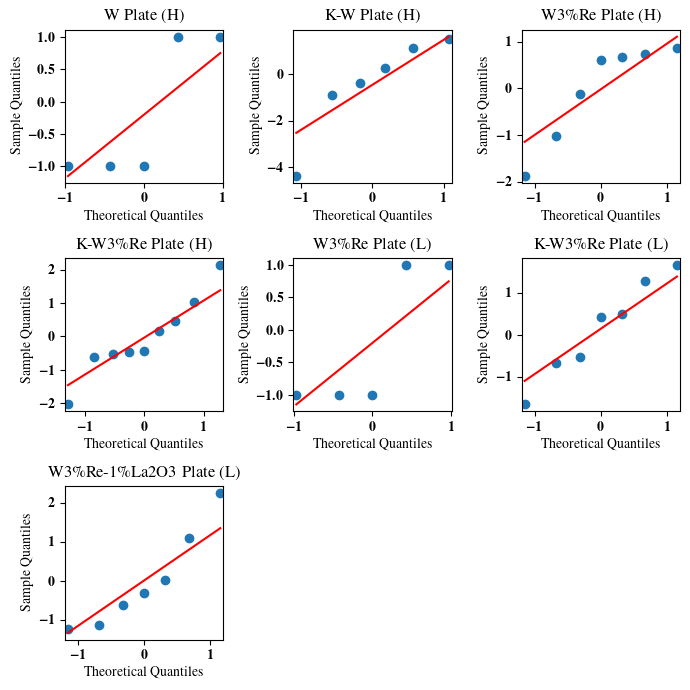

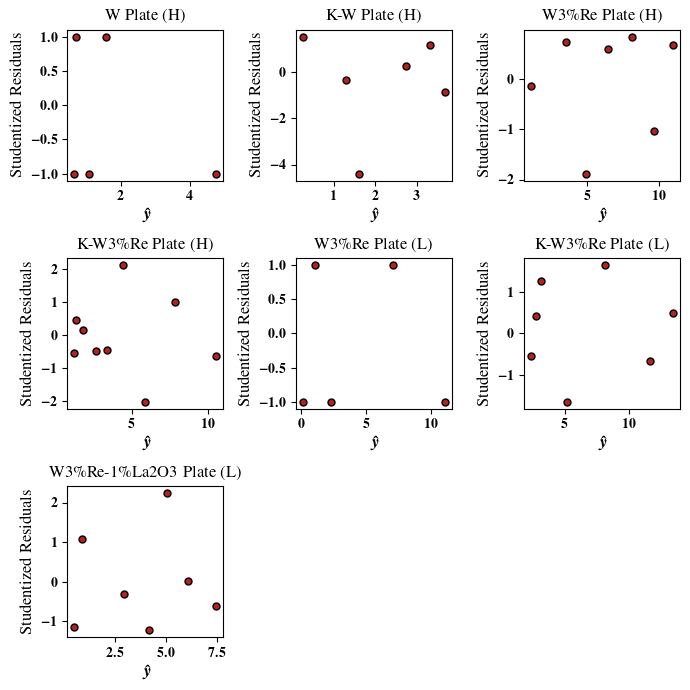

In [5]:
from statsmodels.graphics.gofplots import qqplot
import scipy


fig,axes = plt.subplots(figsize = (7,7),nrows = 3,ncols = 3)
fig2,axes2 = plt.subplots(figsize = (7,7),nrows = 3,ncols = 3)

remove_data = {'UE [%] W Plate (H)': [0,6],
               'UE [%] W3%Re Plate (L)': [2],
               'UE [%] K-W Plate (H)': [0,1,4]}

for column,ax,ax2 in zip(nogami_data.keys(),axes.ravel(),axes2.ravel()):
    label = column[7:].replace('%','\%')
    ax.set_title(label)
    ax2.set_title(label)    

    x,y = nogami_data[column]

    if column in remove_data:
        x,y = clean_data(x,y,remove_data[column])
    

    #make model-data transform pipeline
    pipe = Pipeline([('transform',data_transform),
                        ('model',LinearRegression(fit_intercept= False))])

    pipe.fit(x,y)
    
    #post-porcessing to get diagnostic information
    resid = y - pipe.predict(x)
    X = pipe.named_steps['transform'].transform(x)
    n,p = X.shape
    H = X @ scipy.linalg.pinvh(X.T @ X) @ X.T
                                                                                 

    try:
        S2 = np.sum(resid**2)/(n - p)
        try:
            S2_i = (n - p)/(n- p - 1)*S2 - 1/(n-p -1)*resid**2/(1 - np.diag(H))
        except ZeroDivisionError:
            S2_i = S2

        studentized_residuals = resid/np.sqrt(S2_i*(1 - np.diag(H)))
        leverage = np.diag(H)
        leverage_points = leverage > 2*(X.shape[1] + 1)/X.shape[0]
        
        #print informatoin about potential misfits of data for each data set
        print(f'Alloy: {column} | Data Length: {n}')
        print(f'possible leverage points: {np.arange(0,X.shape[0])[leverage_points]}')
        possible_outliers = np.arange(X.shape[0])[np.abs(studentized_residuals) > 3]
        
        print('possible outliers:')
        print(f'\tindex: {possible_outliers}')
        print(f'\tstudentized residuals: {studentized_residuals[possible_outliers]}')

        
        
        #plot residuals against predicted values and qqplots
        qqplot(studentized_residuals,ax = ax,line = 's',
            color = 'blue')
        ax2.scatter(H @ y,studentized_residuals,edgecolor = 'k',
                    facecolor = 'firebrick',s = 25)
        ax2.set_ylabel('Studentized Residuals',fontsize = 12)
        ax2.set_xlabel('$\hat{y}$',fontsize = 12)

    except ZeroDivisionError:
        print(f'ZeroDivisionError for {column}\n number of data points: {n}\n')
    
    print('\n--------------------------------------------\n\n')

for ax in [axes,axes2]:
    ax[-1,-1].axis('off')
    ax[-1,-2].axis('off') 

fig.tight_layout()
fig2.tight_layout()

### Re-checking Features

Now that we've elimated some data from the models, let's make sure the features we've selected are the right ones. It seems like the still are below.

In [6]:
data= [clean_data(*nogami_data[key], remove_data[key]) if key in remove_data 
       else nogami_data[key] for key in nogami_data.keys()]

feature_transform = get_k_most_commmon_feature_transform(data,3)
print(str(feature_transform))

['1', '1/x', 'x', 'x log x']


### Variability Across Alloys

We can now fit the OLS model on the transformed feature set for each alloy. We'll then sample the predictive distribution, to get upper and lower confidence bounds on the UE as a function of temperature. 

In [7]:
from common_util import hdi
import pickle

def sample_linear_predictive(Xnew: np.ndarray,
                             XtX_inv: np.ndarray,
                             dof: int,
                             S2: float,
                             n: int) -> Tuple[np.ndarray,np.ndarray]:

    return S2**0.5*np.sqrt(1. +  np.sum(Xnew.T*(XtX_inv @ Xnew.T),axis = 0))[:,np.newaxis]*scipy.stats.t.rvs(dof,size = (1,n))

xnew= np.linspace(300,1300,100)[:,np.newaxis]
posterior_samples = []
alloy_uts = dict.fromkeys(nogami_data.keys())

for column in nogami_data.keys():
    if column in remove_data:
        x,y = clean_data(*nogami_data[column], remove_data[column])
    else:
        x,y = nogami_data[column]
    
    pipe = Pipeline([('transform',data_transform),
                     ('model',LinearRegression(fit_intercept= False))])
    pipe.fit(x,y)
    resid = pipe.predict(x) - y
    with open(paths.MODEL.joinpath(f'{column[7:].strip()}_ue.pkl'),'wb') as f:
        pickle.dump(pipe,f)

    X = pipe.named_steps['transform'].transform(x)
    Xp = pipe.named_steps['transform'].transform(xnew)

    S2 = np.sum(resid**2)/(X.shape[0] - X.shape[1])
    
    xtX_inv = scipy.linalg.pinvh(X.T @ X)
    yhat  = pipe.predict(xnew)
    alloy_uts[column]  = yhat.copy()
    posterior_samples.append(
        yhat[:,np.newaxis] + sample_linear_predictive(Xp,xtX_inv,X.shape[0] - X.shape[1],S2,20000)
    )

    print(f'{column}: R2: {round(pipe.score(x,y),4)} | std. dev.: {round(S2**0.5,2)}')

posterior_samples = np.concatenate(posterior_samples,axis = 1)
with open(paths.SCRATCH.joinpath('ue_posterior_samples.pkl'),'wb') as f:
    pickle.dump((xnew,posterior_samples),f)

low_uts,high_uts = hdi(posterior_samples,0.95).T
mean_uts = np.mean(posterior_samples,axis = 1)


UE [%] W Plate (H): R2: 0.9995 | std. dev.: 0.08
UE [%] K-W Plate (H): R2: 0.9594 | std. dev.: 0.43
UE [%] W3%Re Plate (H): R2: 0.9965 | std. dev.: 0.29
UE [%] K-W3%Re Plate (H): R2: 0.9462 | std. dev.: 0.96
UE [%] W3%Re Plate (L): R2: 0.9998 | std. dev.: 0.12
UE [%] K-W3%Re Plate (L): R2: 0.966 | std. dev.: 1.19
UE [%] W3%Re-1%La2O3 Plate (L): R2: 0.9507 | std. dev.: 0.84


### Visualizing Important UE Functions.

For future analysis, we'd like to select specific curves of interest that have intrinsic meaning. To that end, there are four uniform elongation functions we care about: 

1. The expected value of the K-W3\%Re Plate (L) alloy.
2. The expected value of the K-W3\%Re Plate (H) alloy. 
3. The overall expected value across all alloys. 
4. An upper confidence interval. 
 

Similar for the UTS (now for (H) vs. (L)), the predicted value for the K-W3\%Re Plate (H) alloy and the overall mean essentially coincide. This has the useful interpretation of the  K-W3\%Re Plate (H) essentially being an "average" alloy.

The lower bound in this case is essentially meaningless, as $\varepsilon_u \leq 2 \%$ imply the material is effectively brittle. This means that the upper confidence interval will represent an _optimistic_ estimate bound while the lower bound is $\varepsilon_u = 0 \ \forall T$

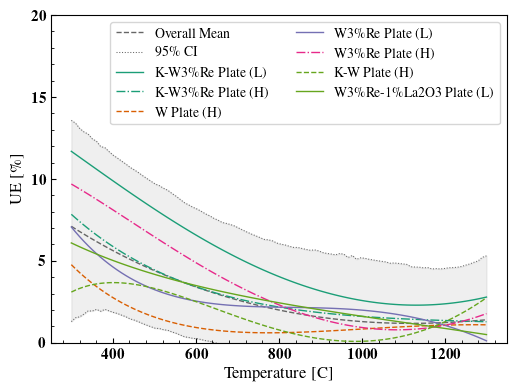

In [11]:
fig,ax = plt.subplots(figsize = (5,3.75))
setup_axis_default(ax)
ax.set_xlabel('Temperature [C]',fontsize = 12)
ax.set_ylabel('UE [\%]',fontsize = 12)

sum_color = plt.get_cmap('Dark2')(0.9)
ax.plot(xnew,mean_uts,lw = 1.,zorder = 100,color = sum_color,ls = '--',label = 'Overall Mean')
ax.plot(xnew,low_uts,lw = 0.75,color  = sum_color,ls = ':',label = '95\% CI') 
ax.plot(xnew,high_uts,lw = 0.75,color  = sum_color,ls = ':')
ax.fill_between(xnew[:,0],low_uts,high_uts,color = sum_color,alpha = 0.1)

labels = {'UE [%] K-W3%Re Plate (L)':'K-W3\%Re Plate (L)',
          'UE [%] K-W3%Re Plate (H)': 'K-W3\%Re Plate (H)',
          'UE [%] W Plate (H)': 'W Plate (H)',
          'UE [%] W3%Re Plate (L)': 'W3\%Re Plate (L)',
          'UE [%] W3%Re Plate (H)': 'W3\%Re Plate (H)',
          'UE [%] K-W Plate (H)': 'K-W Plate (H)',
          'UE [%] W3%Re-1%La2O3 Plate (L)': 'W3\%Re-1\%La2O3 Plate (L)',}

for alloy,color,ls in zip(labels,plt.get_cmap('Dark2')(np.arange(0,1,0.1)),['-','-.','--','-','-.','--','-']):
    ax.plot(xnew,alloy_uts[alloy],lw = 1.,zorder = 100,color = color,
            label = labels[alloy],ls = ls)

ax.legend(fontsize = 10,ncols = 2)  
ax.set_yticks(np.arange(0,25,5))
ax.set_ylim([0,20])

fig.tight_layout(pad = 0.1)

### Final Visualizations over the Data

Finally, let's visualize these three functions over the whole gathered dataset of UE. I'll omit showing the "overall mean" now that we understand this is well represented by the expected value of the K-W3\%Re Plate (H) alloy. 

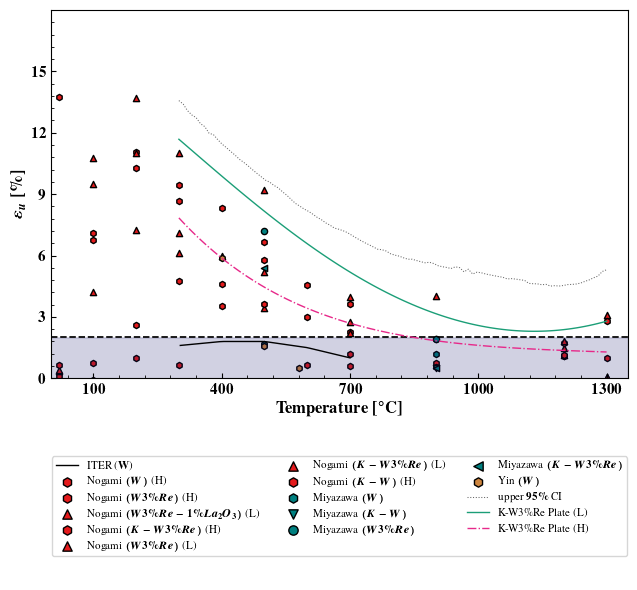

In [14]:
import pickle

with open(paths.SCRATCH.joinpath('ue_data_fig.pkl'),'rb') as f:
    data = pickle.load(f)
    fig,axes = data
    ax,legend_ax= axes

sum_color = plt.get_cmap('Dark2')(0.9)
ax.plot(xnew,high_uts,lw = 0.75,color  = sum_color,ls = ':',label = 'upper $95\%$ CI') 

labels = {'UE [%] K-W3%Re Plate (L)':'K-W3\%Re Plate (L)',
          'UE [%] K-W3%Re Plate (H)': 'K-W3\%Re Plate (H)'}

for alloy,color,ls in zip(labels,plt.get_cmap('Dark2')([0.1,0.4]),['-','-.']):
    ax.plot(xnew,alloy_uts[alloy],lw = 1.,zorder = 100,color = color,
            label = labels[alloy],ls = ls)

legend,handles = ax.get_legend_handles_labels()
legend_ax.legend(handles = legend,loc = 'center',ncol = 3,fontsize = 8,markerscale = 1.5) 
fig.savefig(paths.GIT_IMAGES.joinpath('ue_data_fit.svg'),bbox_inches = 'tight')